In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import MultipleLocator
from tslearn.piecewise import SymbolicAggregateApproximation
from hmmlearn.hmm import CategoricalHMM
import random
from sklearn.model_selection import KFold
from sklearn import preprocessing
import scipy.stats as stats
from scipy.stats import f_oneway
import ptitprince as pt
import matplotlib.collections as clt

# purpose
1. Use SAX change continuous data to discrete data
2. downsample data to state
    + find the shortest flat sub-series
    + use it as the unit of the whole series
    + downsample it with the unit
3. use HMM on the downsampled series per participant
4. change parameter and find the best fit model

In [3]:
class participant:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D4_rating=[]
    def __str__(self):
        print("participant: "+self.PID)
        print("Visit 1: "+str(len(self.D1_rating)))
        print("Visit 4: "+str(len(self.D4_rating)))
        return ""
    def update_rating(self,D1,D4):
        self.D1_rating=D1
        self.D4_rating=D4

In [4]:
Carl_chronic_df=pd.read_pickle("../data/CBP_rating.pkl")
Carl_subacute_df=pd.read_pickle("../data/SBP_rating.pkl")
Carl_classify=pd.read_pickle("../data/class.pkl")
cbp_participant_list=[]
sbpr_participant_list=[]
sbpp_participant_list=[]
class_pain={}
for index,row in Carl_classify.iterrows():
    if row['subject'] not in class_pain:
        class_pain[row['subject']]=row['classification']
PID_list=[]
for index,row in Carl_chronic_df.iterrows():
    if row['PID'] not in PID_list:
        PID_list.append(row['PID'])
    else:
        continue
    if row['D1_rating']!=[] and row['D4_rating']!=[]:
        part=participant(row['PID'])
        part.update_rating(row['D1_rating'],row['D4_rating'])
        cbp_participant_list.append(part)
for index,row in Carl_subacute_df.iterrows():
    if row['PID'] not in PID_list:
        PID_list.append(row['PID'])
    else:
        continue
    if class_pain[row['PID']]=='SBPr':
        if row['D1_rating']!=[] and row['D4_rating']!=[]:
            part=participant(row['PID'])
            part.update_rating(row['D1_rating'],row['D4_rating'])
            sbpr_participant_list.append(part)
    elif class_pain[row['PID']]=='SBPp':
        if row['D1_rating']!=[] and row['D4_rating']!=[]:
            part=participant(row['PID'])
            part.update_rating(row['D1_rating'],row['D4_rating'])
            sbpp_participant_list.append(part)
    else:
        print(row['PID']+"error")

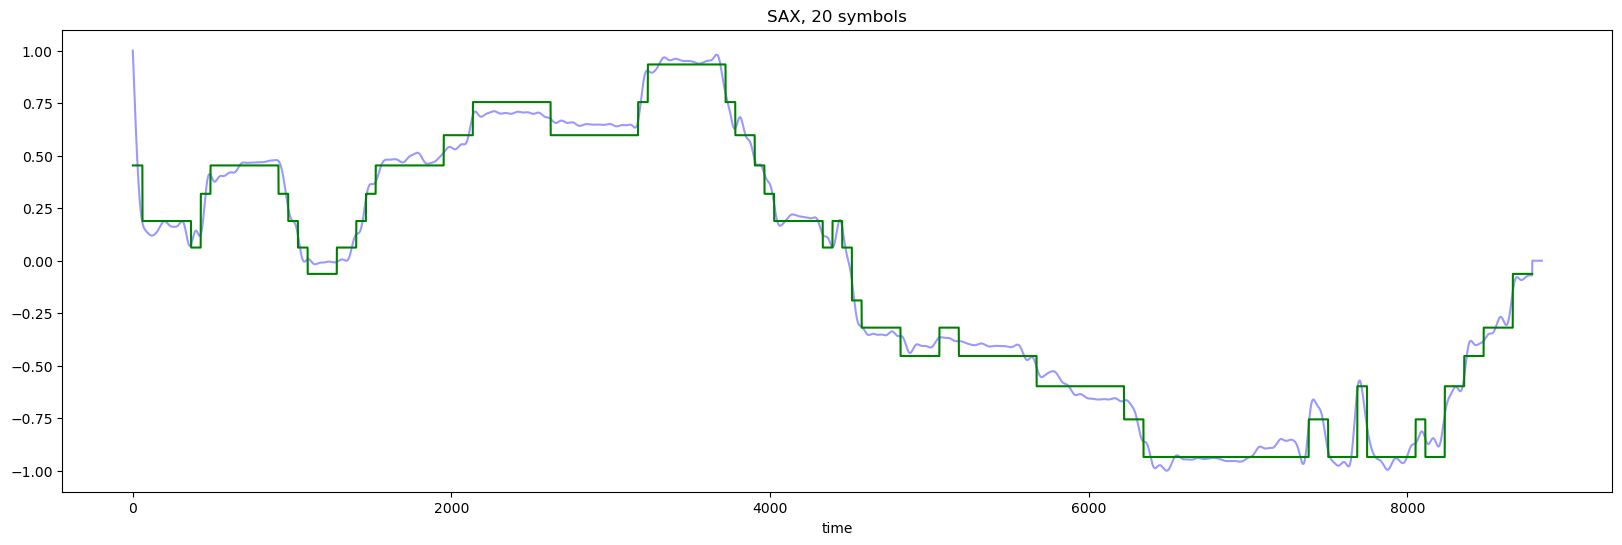

In [5]:
def add_dim(data):
    rating=np.array(data)
    rating_new=np.expand_dims(rating, 0)
    rating_new=np.expand_dims(rating_new, 2)
    return rating_new
def SAX_rating(rating,n_paa_segments,n_sax_symbols, plot=False):
    # print(len(rating))
    if type(rating)!=np.ndarray:
        rating=np.array(rating)
    rating_norm = (rating-np.min(rating))/(np.max(rating)-np.min(rating))
    rating_norm=np.array(rating_norm)*2-1
    add_length=int(len(rating)/n_paa_segments)
    rating_norm=rating_norm.tolist()+[0]*add_length
    rating=add_dim(rating_norm)
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
    sax_dataset_inv = sax.inverse_transform(sax.fit_transform(rating))
    output=sax_dataset_inv[0].ravel()
    if plot==True:
        plt.figure(figsize=(20, 6))
        plt.plot(rating[0].ravel(), "b-", alpha=0.4)
        plt.plot(output[:-1*add_length], "g-")
        plt.title("SAX, %d symbols" % n_sax_symbols)
        plt.xlabel("time")
        plt.show()
    return output[:-1*add_length]
Sax_sample=SAX_rating(cbp_participant_list[0].D1_rating,144,20,True)

In [6]:
def detect_shortest_flat_subseries(SAX_series):
    length_list=[]
    flat_length=0
    pre_point=SAX_series[0]
    # print(len(SAX_series)-1)
    for point_i,point in enumerate(SAX_series):
        if point==pre_point:
            flat_length+=1
            if point_i==len(SAX_series)-1:
                length_list.append(flat_length)
        else:
            length_list.append(flat_length)
            flat_length=1
            pre_point=point
        # print("i: "+str(point_i),end=" ")
        # print("point: "+str(point),end=" ")
        # print("pre point: "+str(pre_point),end=" ")
        # print("flat length: "+str(flat_length))
        # min_flat=min(length_list.items(), key=lambda item: item[1])
    return min(length_list)
flat_length=detect_shortest_flat_subseries(Sax_sample)
print(flat_length)

61


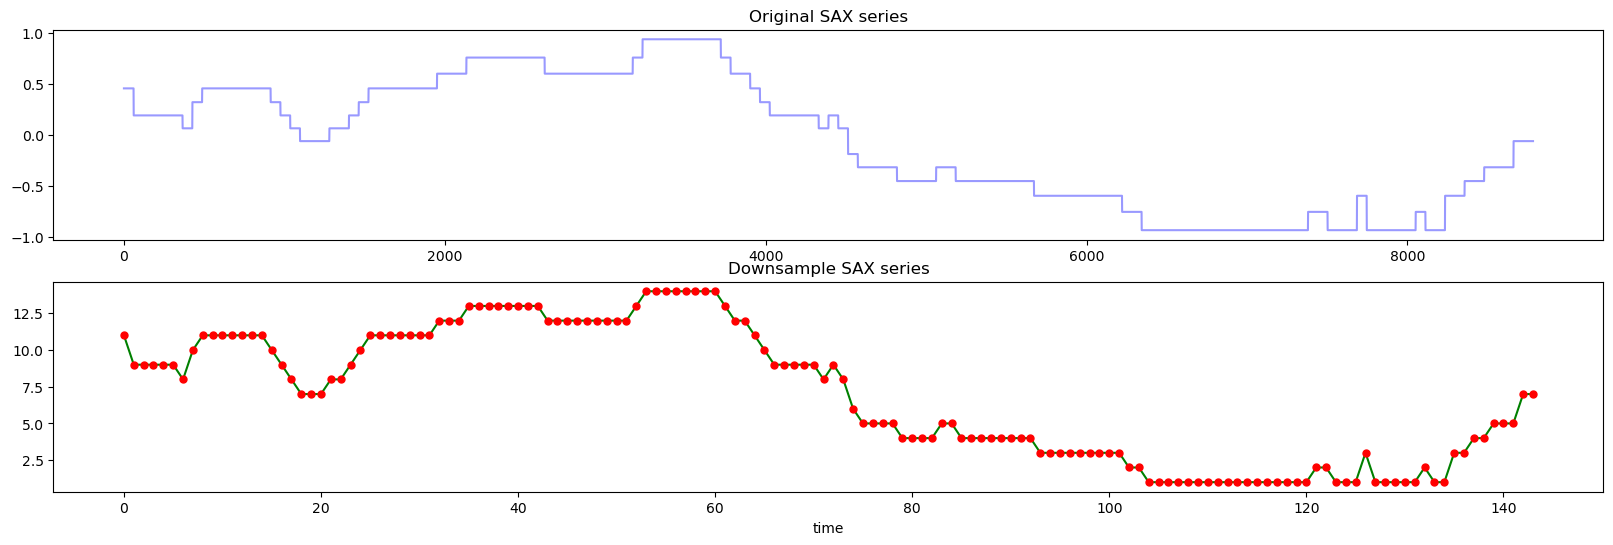

In [7]:
def downsample_SAX(SAX_rating,n_paa_segments,multi=1,plot=False):
    flat_length=int(len(SAX_rating)/n_paa_segments)
    downsample_SAX_list=[]
    label_set=sorted(set(SAX_rating))
    int_label_dic={}
    for label_i,label in enumerate(label_set):
        # print(label)
        int_label_dic[label]=label_i+1
    for point in SAX_rating[::flat_length]:
        for multi_i in range(multi):
            downsample_SAX_list.append(int_label_dic[point])
    if plot==True:
        # fig, ax = plt.subplots(2, 1)
        # fig.tight_layout()
        plt.figure(figsize=(20, 6))
        plt.subplot(2, 1, 1)
        plt.plot(SAX_rating.ravel(), "b-", alpha=0.4)
        plt.title("Original SAX series")
        plt.subplot(2, 1, 2)
        plt.plot(downsample_SAX_list, "g-",marker ='.',mfc='red', mec='red',ms=10)
        plt.title("Downsample SAX series")
        plt.xlabel("time")
        plt.show()
    return np.array(downsample_SAX_list)
n_paa=144
downsample_SAX_sample=downsample_SAX(Sax_sample,n_paa,multi=1,plot=True)

In [16]:
len(downsample_SAX_sample)

144

In [67]:
# Reshape the observed data to a 2D array (required by hmmlearn)
observed_SAX_rating_sample = downsample_SAX_sample.reshape(-1, 1)
# Create and train the Gaussian HMM model
num_states = 10
model_sample = CategoricalHMM(n_components=num_states)
model_sample.fit(observed_SAX_rating_sample)
type(model_sample)

Fitting a model with 239 free scalar parameters with only 144 data points will result in a degenerate solution.


hmmlearn.hmm.CategoricalHMM

## try different downsample size

In [351]:
log_likelihood_list=[]
aic_list=[]
bic_list=[]
for dsp_i in tqdm(range(1,flat_length)):
    downsample_SAX_sample=downsample_SAX(Sax_sample,n_paa,multi=dsp_i,plot=False)
    observed_SAX_rating_sample = downsample_SAX_sample.reshape(-1, 1)
    # Create and train the Gaussian HMM model
    num_states = 10
    model_sample = CategoricalHMM(n_components=num_states)
    model_sample.fit(observed_SAX_rating_sample)
    # observed_data = Carl_rating_AllinOne.reshape(-1, 1)
    log_likelihood = model_sample.score(observed_SAX_rating_sample)
    log_likelihood_list.append(log_likelihood)

    # Get the number of parameters in the model
    num_params = model_sample.n_features * model_sample.n_components + (model_sample.n_components - 1) * model_sample.n_components

    # Calculate the Akaike Information Criterion (AIC)
    aic = -2 * log_likelihood + 2 * num_params

    # Calculate the Bayesian Information Criterion (BIC)
    bic = -2 * log_likelihood + num_params * np.log(len(observed_SAX_rating_sample))

    # Display the AIC and BIC
    aic_list.append(aic)
    bic_list.append(bic)

  0%|          | 0/60 [00:00<?, ?it/s]

Fitting a model with 239 free scalar parameters with only 144 data points will result in a degenerate solution.


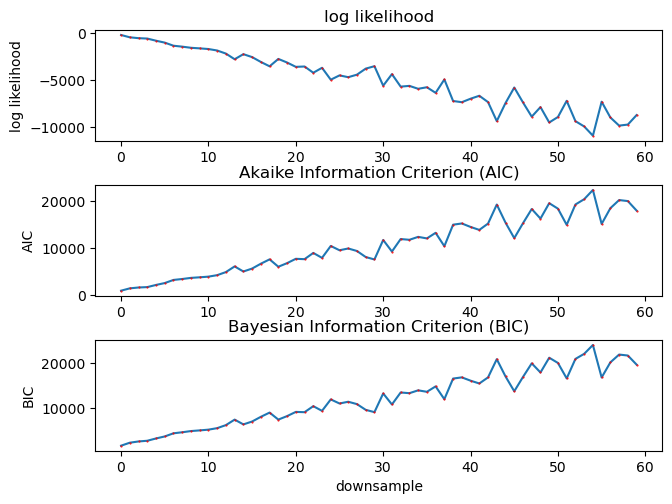

In [352]:
fig, ax = plt.subplots(3, 1)
fig.tight_layout()
plt.subplot(3, 1, 1)
plt.plot(log_likelihood_list,marker ='.',mfc='red', mec='red',ms=1)
plt.title("log likelihood")
# plt.xlabel("downsample")
plt.ylabel("log likelihood")
plt.subplot(3, 1, 2)
plt.plot(aic_list,marker ='.',mfc='red', mec='red',ms=1)
plt.title("Akaike Information Criterion (AIC)")
# plt.xlabel("downsample")
plt.ylabel("AIC")
plt.subplot(3, 1, 3)
plt.plot(bic_list,marker ='.',mfc='red', mec='red',ms=1)
plt.title("Bayesian Information Criterion (BIC)")
plt.xlabel("downsample")
plt.ylabel("BIC")
plt.show()

## try different hidden state

In [370]:
log_likelihood_list=[]
aic_list=[]
bic_list=[]
results={}
for nst_i in tqdm(range(5,31)):
    print(nst_i,end=" ")
    downsample_SAX_sample=downsample_SAX(Sax_sample,n_paa,multi=10,plot=False)
    observed_SAX_rating_sample = downsample_SAX_sample.reshape(-1, 1)
    # Create and train the Gaussian HMM model
    num_states = nst_i
    model_sample = CategoricalHMM(n_components=num_states)
    model_sample.fit(observed_SAX_rating_sample)
    # observed_data = Carl_rating_AllinOne.reshape(-1, 1)
    log_likelihood = model_sample.score(observed_SAX_rating_sample)
    log_likelihood_list.append(log_likelihood)

    # Get the number of parameters in the model
    num_params = model_sample.n_features * model_sample.n_components + (model_sample.n_components - 1) * model_sample.n_components

    # Calculate the Akaike Information Criterion (AIC)
    aic = -2 * log_likelihood + 2 * num_params

    # Calculate the Bayesian Information Criterion (BIC)
    bic = -2 * log_likelihood + num_params * np.log(len(observed_SAX_rating_sample))

    # Display the AIC and BIC
    aic_list.append(aic)
    bic_list.append(bic)
    results[nst_i]={"log_likelihood":log_likelihood,"aic":aic,"bic":bic}

  0%|          | 0/26 [00:00<?, ?it/s]

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

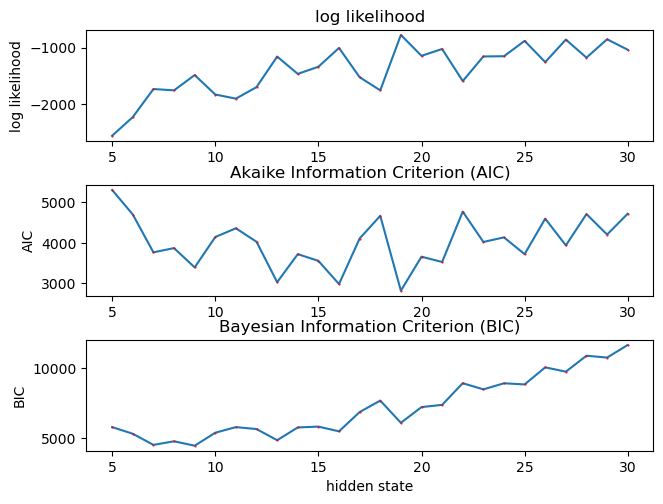

In [381]:
xlabel=range(5,35,5)
default_x_ticks = range(0,30,5)
fig, ax = plt.subplots(3, 1)
fig.tight_layout()
plt.subplot(3, 1, 1)
plt.plot(log_likelihood_list,marker ='.',mfc='red', mec='red',ms=1)
plt.xticks(default_x_ticks,xlabel)
plt.title("log likelihood")
# plt.xlabel("downsample")
plt.ylabel("log likelihood")
plt.subplot(3, 1, 2)
plt.plot(aic_list,marker ='.',mfc='red', mec='red',ms=1)
plt.xticks(default_x_ticks,xlabel)
plt.title("Akaike Information Criterion (AIC)")
# plt.xlabel("downsample")
plt.ylabel("AIC")
plt.subplot(3, 1, 3)
plt.plot(bic_list,marker ='.',mfc='red', mec='red',ms=1)
plt.xticks(default_x_ticks,xlabel)
plt.title("Bayesian Information Criterion (BIC)")
plt.xlabel("hidden state")
plt.ylabel("BIC")
plt.show()

In [13]:
def normalize(result_list,minus=False):
    result_list_np=np.array(result_list)
    if minus==True:
        result_list_np=result_list_np*-1
    normalized_arr = preprocessing.normalize([result_list_np])
    return normalized_arr[0]
def select_nstate(SAX_rating,nstate_start,nstate_end,n_paa,multi_num,plot=False):
    log_likelihood_list=[]
    aic_list=[]
    bic_list=[]
    model_list={}
    for nst_i in range(nstate_start,nstate_end):
        # print(nst_i,end=" ")
        downsample_SAX_sample=downsample_SAX(SAX_rating,n_paa,multi=multi_num,plot=False)
        observed_SAX_rating_sample = downsample_SAX_sample.reshape(-1, 1)
        # Create and train the Gaussian HMM model
        num_states = nst_i
        model_sample = CategoricalHMM(n_components=num_states)
        model_sample.fit(observed_SAX_rating_sample)
        model_list[nst_i]=model_sample
        # observed_data = Carl_rating_AllinOne.reshape(-1, 1)
        log_likelihood = model_sample.score(observed_SAX_rating_sample)
        log_likelihood_list.append(log_likelihood)
        # Calculate the Akaike Information Criterion (AIC)
        aic = model_sample.aic(observed_SAX_rating_sample)
        # Calculate the Bayesian Information Criterion (BIC)
        bic = model_sample.bic(observed_SAX_rating_sample)
        # Display the AIC and BIC
        aic_list.append(aic)
        bic_list.append(bic)
    if plot==True:
        xlabel=range(nstate_start,nstate_end,5)
        default_x_ticks = range(0,nstate_end-nstate_start,5)
        fig, ax = plt.subplots(3, 1)
        fig.tight_layout()
        plt.subplot(3, 1, 1)
        plt.plot(log_likelihood_list,marker ='.',mfc='red', mec='red',ms=1)
        plt.xticks(default_x_ticks,xlabel)
        plt.title("log likelihood")
        plt.ylabel("log likelihood")
        plt.subplot(3, 1, 2)
        plt.plot(aic_list,marker ='.',mfc='red', mec='red',ms=1)
        plt.xticks(default_x_ticks,xlabel)
        plt.title("Akaike Information Criterion (AIC)")
        plt.ylabel("AIC")
        plt.subplot(3, 1, 3)
        plt.plot(bic_list,marker ='.',mfc='red', mec='red',ms=1)
        plt.xticks(default_x_ticks,xlabel)
        plt.title("Bayesian Information Criterion (BIC)")
        plt.xlabel("downsample")
        plt.ylabel("BIC")
        plt.show()
    ### Score Strategy No.1
    # log_norm=normalize(log_likelihood_list)
    # aic_norm=normalize(aic_list,True)
    # bic_norm=normalize(bic_list,True)
    # total_score=log_norm*2+aic_norm+bic_norm
    ### Score Strategy No.2
    aic_norm=normalize(aic_list)
    bic_norm=normalize(bic_list)
    total_score=aic_norm+bic_norm
    score_dic={}
    for score_i in range(nstate_start,nstate_end):
        score_dic[score_i]={"log":log_likelihood_list[score_i-nstate_start],"aic":aic_list[score_i-nstate_start],"bic":bic_list[score_i-nstate_start],"score":total_score[score_i-nstate_start]}
    max_index=min(score_dic, key=lambda v: score_dic[v]["score"])
    best_score=score_dic[max_index]
    return max_index,best_score["log"],best_score["aic"],best_score["bic"],best_score["score"],model_list

  0%|          | 0/50 [00:00<?, ?it/s]

Fitting a model with 1471 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1550 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1631 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1471 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1550 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1631 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1471 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1550 free scalar parameters with only 1440 data points will result in a degenerate solution.
Fitting a model with 1631 free scalar parameters with only 1440 data points will result 

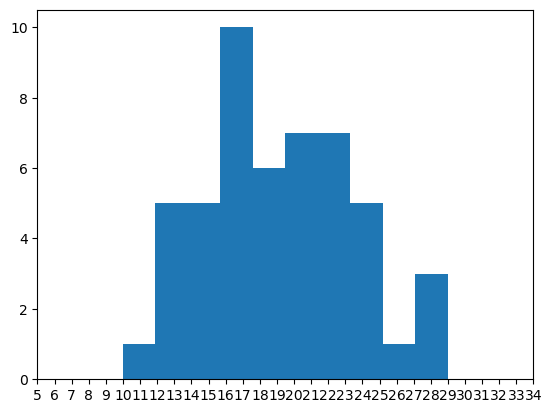

19.16

In [20]:
result_list=[]
for i in tqdm(range(50)):
    best_nstate,log,aic,bic,score=select_nstate(Sax_sample,5,35,144,10)
    result_list.append(best_nstate)
plt.hist(result_list, bins=10)
plt.xticks(np.arange(5,35))
plt.show()
np.mean(result_list)

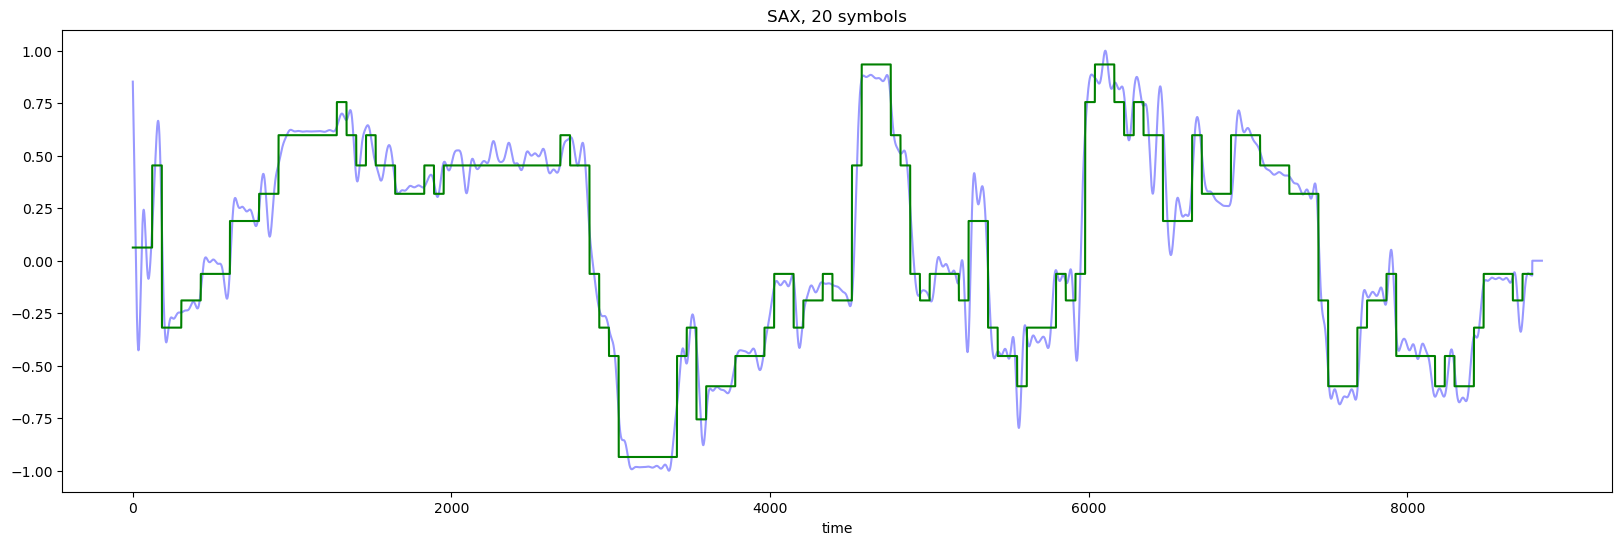

  0%|          | 0/5 [00:00<?, ?it/s]

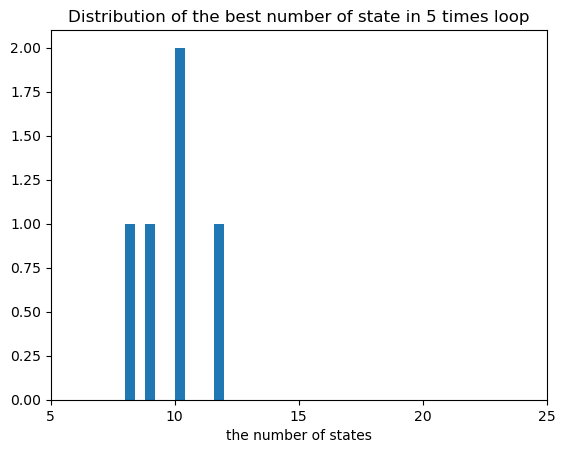

best number of state: 9


In [14]:
def find_bestnstate_modelscore(rating,n_paa,n_sax,nstate_start,nstate_end,multi_num,nloop,plot_rating=False,plot=False):
    Sax_rating=SAX_rating(rating,n_paa,n_sax, plot=plot_rating)
    n_state_list=[]
    log_list=[]
    aic_list=[]
    bic_list=[]
    score_list=[]
    model_list_loop=[]
    for i in tqdm(range(nloop)):
        best_nstate,log,aic,bic,score,model_list=select_nstate(Sax_rating,nstate_start,nstate_end,n_paa,multi_num,plot=False)
        n_state_list.append(best_nstate)
        log_list.append(log)
        aic_list.append(aic)
        bic_list.append(bic)
        score_list.append(score)
        model_list_loop.append(model_list)
    if plot==True:
        plt.hist(n_state_list, bins=10)
        plt.xticks(np.arange(nstate_start,nstate_end,5))
        plt.title("Distribution of the best number of state in "+str(nloop)+" times loop")
        plt.xlabel("the number of states")
        plt.show()
    return int(np.mean(n_state_list)),np.mean(log_list),np.mean(aic_list),np.mean(bic_list),np.mean(score_list),model_list_loop
n_state,log,aic,bic,score,model_L_L=find_bestnstate_modelscore(cbp_participant_list[5].D1_rating,144,20,5,26,10,5,True,True)
print("best number of state: "+str(n_state))

In [15]:
cbp_nstate_D1=[]
cbp_nstate_D4=[]
sbpr_nstate_D1=[]
sbpr_nstate_D4=[]
sbpp_nstate_D1=[]
sbpp_nstate_D4=[]
cbp_score_D1=[]
cbp_score_D4=[]
sbpr_score_D1=[]
sbpr_score_D4=[]
sbpp_score_D1=[]
sbpp_score_D4=[]
cbp_log_D1=[]
cbp_log_D4=[]
sbpr_log_D1=[]
sbpr_log_D4=[]
sbpp_log_D1=[]
sbpp_log_D4=[]
cbp_aic_D1=[]
cbp_aic_D4=[]
sbpr_aic_D1=[]
sbpr_aic_D4=[]
sbpp_aic_D1=[]
sbpp_aic_D4=[]
cbp_bic_D1=[]
cbp_bic_D4=[]
sbpr_bic_D1=[]
sbpr_bic_D4=[]
sbpp_bic_D1=[]
sbpp_bic_D4=[]
PID_Day_list=[]
model_LL_list=[]
n_paa=144
n_sax=20
nstate_start=5
nstate_end=26
multi_num=10
nloop=10
print("------chronic back pain------")
for part in tqdm(cbp_participant_list):
    n_state,log,aic,bic,score,model_LL=find_bestnstate_modelscore(part.D1_rating,n_paa,n_sax,nstate_start,nstate_end,multi_num,nloop,False,False)
    cbp_nstate_D1.append(n_state)
    cbp_score_D1.append(score)
    cbp_log_D1.append(log)
    cbp_aic_D1.append(aic)
    cbp_bic_D1.append(bic)
    PID_Day_list.append(part.PID+"_Day1")
    model_LL_list.append(model_LL)
    n_state,log,aic,bic,score,model_LL=find_bestnstate_modelscore(part.D4_rating,n_paa,n_sax,nstate_start,nstate_end,multi_num,nloop,False,False)
    cbp_nstate_D4.append(n_state)
    cbp_score_D4.append(score)
    cbp_log_D4.append(log)
    cbp_aic_D4.append(aic)
    cbp_bic_D4.append(bic)
    PID_Day_list.append(part.PID+"_Day4")
    model_LL_list.append(model_LL)
print("------subacute pain (recovery)------")
for part in tqdm(sbpr_participant_list):
    n_state,log,aic,bic,score,model_LL=find_bestnstate_modelscore(part.D1_rating,n_paa,n_sax,nstate_start,nstate_end,multi_num,nloop,False,False)
    sbpr_nstate_D1.append(n_state)
    sbpr_score_D1.append(score)
    sbpr_log_D1.append(log)
    sbpr_aic_D1.append(aic)
    sbpr_bic_D1.append(bic)
    PID_Day_list.append(part.PID+"_Day1")
    model_LL_list.append(model_LL)
    n_state,log,aic,bic,score,model_LL=find_bestnstate_modelscore(part.D4_rating,n_paa,n_sax,nstate_start,nstate_end,multi_num,nloop,False,False)
    sbpr_nstate_D4.append(n_state)
    sbpr_score_D4.append(score)
    sbpr_log_D4.append(log)
    sbpr_aic_D4.append(aic)
    sbpr_bic_D4.append(bic)
    PID_Day_list.append(part.PID+"_Day4")
    model_LL_list.append(model_LL)
print("------subacute pain (persist)------")
for part in tqdm(sbpp_participant_list):
    n_state,log,aic,bic,score,model_LL=find_bestnstate_modelscore(part.D1_rating,n_paa,n_sax,nstate_start,nstate_end,multi_num,nloop,False,False)
    sbpp_nstate_D1.append(n_state)
    sbpp_score_D1.append(score)
    sbpp_log_D1.append(log)
    sbpp_aic_D1.append(aic)
    sbpp_bic_D1.append(bic)
    PID_Day_list.append(part.PID+"_Day1")
    model_LL_list.append(model_LL)
    n_state,log,aic,bic,score,model_LL=find_bestnstate_modelscore(part.D4_rating,n_paa,n_sax,nstate_start,nstate_end,multi_num,nloop,False,False)
    sbpp_nstate_D4.append(n_state)
    sbpp_score_D4.append(score)
    sbpp_log_D4.append(log)
    sbpp_aic_D4.append(aic)
    sbpp_bic_D4.append(bic)
    PID_Day_list.append(part.PID+"_Day4")
    model_LL_list.append(model_LL)

------chronic back pain------


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

------subacute pain (recovery)------


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

------subacute pain (persist)------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
# cbp_nstate_D1
# cbp_nstate_D4
# sbpr_nstate_D1
# sbpr_nstate_D4
# sbpp_nstate_D1
# sbpp_nstate_D4
# cbp_score_D1
# cbp_score_D4
# sbpr_score_D1
# sbpr_score_D4
# sbpp_score_D1
# sbpp_score_D4
cbp_D1=pd.DataFrame({
    "n_state":cbp_nstate_D1,
    "score":cbp_score_D1,
    "log":cbp_log_D1,
    "aic":cbp_aic_D1,
    "bic":cbp_bic_D1
})
cbp_D4=pd.DataFrame({
    "n_state":cbp_nstate_D4,
    "score":cbp_score_D4,
    "log":cbp_log_D4,
    "aic":cbp_aic_D4,
    "bic":cbp_bic_D4
})
sbpr_D1=pd.DataFrame({
    "n_state":sbpr_nstate_D1,
    "score":sbpr_score_D1,
    "log":sbpr_log_D1,
    "aic":sbpr_aic_D1,
    "bic":sbpr_bic_D1
})
sbpr_D4=pd.DataFrame({
    "n_state":sbpr_nstate_D4,
    "score":sbpr_score_D4,
    "log":sbpr_log_D4,
    "aic":sbpr_aic_D4,
    "bic":sbpr_bic_D4
})
sbpp_D1=pd.DataFrame({
    "n_state":sbpp_nstate_D1,
    "score":sbpp_score_D1,
    "log":sbpp_log_D1,
    "aic":sbpp_aic_D1,
    "bic":sbpp_bic_D1
})
sbpp_D4=pd.DataFrame({
    "n_state":sbpp_nstate_D4,
    "score":sbpp_score_D4,
    "log":sbpp_log_D4,
    "aic":sbpp_aic_D4,
    "bic":sbpp_bic_D4
})
model_df=pd.DataFrame({
    "PID_Day":PID_Day_list,
    "model_LL":model_LL_list
})
cbp_D1.to_pickle("../data/part_score/S2/cbp_D1_S2.pkl")
cbp_D4.to_pickle("../data/part_score/S2/cbp_D4_S2.pkl")
sbpr_D1.to_pickle("../data/part_score/S2/sbpr_D1_S2.pkl")
sbpr_D4.to_pickle("../data/part_score/S2/sbpr_D4_S2.pkl")
sbpp_D1.to_pickle("../data/part_score/S2/sbpp_D1_S2.pkl")
sbpp_D4.to_pickle("../data/part_score/S2/sbpp_D4_S2.pkl")
model_df.to_pickle("../data/model_LL/S2/model_LL_S2.pkl")

In [3]:
cbp_D1=pd.read_pickle("../data/part_score/S2/cbp_D1_S2.pkl")
cbp_D4=pd.read_pickle("../data/part_score/S2/cbp_D4_S2.pkl")
sbpr_D1=pd.read_pickle("../data/part_score/S2/sbpr_D1_S2.pkl")
sbpr_D4=pd.read_pickle("../data/part_score/S2/sbpr_D4_S2.pkl")
sbpp_D1=pd.read_pickle("../data/part_score/S2/sbpp_D1_S2.pkl")
sbpp_D4=pd.read_pickle("../data/part_score/S2/sbpp_D4_S2.pkl")

In [4]:
cbp_nstate_D1=cbp_D1['n_state']
cbp_score_D1=cbp_D1['score']
cbp_log_D1=cbp_D1['log']
cbp_aic_D1=cbp_D1['aic']
cbp_bic_D1=cbp_D1['bic']
cbp_nstate_D4=cbp_D4['n_state']
cbp_score_D4=cbp_D4['score']
cbp_log_D4=cbp_D4['log']
cbp_aic_D4=cbp_D4['aic']
cbp_bic_D4=cbp_D4['bic']
sbpr_nstate_D1=sbpr_D1['n_state']
sbpr_score_D1=sbpr_D1['score']
sbpr_log_D1=sbpr_D1['log']
sbpr_aic_D1=sbpr_D1['aic']
sbpr_bic_D1=sbpr_D1['bic']
sbpr_nstate_D4=sbpr_D4['n_state']
sbpr_score_D4=sbpr_D4['score']
sbpr_log_D4=sbpr_D4['log']
sbpr_aic_D4=sbpr_D4['aic']
sbpr_bic_D4=sbpr_D4['bic']
sbpp_nstate_D1=sbpp_D1['n_state']
sbpp_score_D1=sbpp_D1['score']
sbpp_log_D1=sbpp_D1['log']
sbpp_aic_D1=sbpp_D1['aic']
sbpp_bic_D1=sbpp_D1['bic']
sbpp_nstate_D4=sbpp_D4['n_state']
sbpp_score_D4=sbpp_D4['score']
sbpp_log_D4=sbpp_D4['log']
sbpp_aic_D4=sbpp_D4['aic']
sbpp_bic_D4=sbpp_D4['bic']

In [35]:
print("CBP V1")
print("n_state:"+str(round(np.mean(cbp_nstate_D1),4)),end="\t")
print("score:"+str(round(np.mean(cbp_score_D1),4)),end="\t")
print("log:"+str(round(np.mean(cbp_log_D1),4)),end="\t")
print("aic:"+str(round(np.mean(cbp_aic_D1),4)),end="\t")
print("bic:"+str(round(np.mean(cbp_bic_D1),4)))

print("CBP V4")
print("n_state:"+str(round(np.mean(cbp_nstate_D4),4)),end="\t")
print("score:"+str(round(np.mean(cbp_score_D4),4)),end="\t")
print("log:"+str(round(np.mean(cbp_log_D4),4)),end="\t")
print("aic:"+str(round(np.mean(cbp_aic_D4),4)),end="\t")
print("bic:"+str(round(np.mean(cbp_bic_D4),4)))

print("SBPr V1")
print("n_state:"+str(round(np.mean(sbpr_nstate_D1),4)),end="\t")
print("score:"+str(round(np.mean(sbpr_score_D1),4)),end="\t")
print("log:"+str(round(np.mean(sbpr_log_D1),4)),end="\t")
print("aic:"+str(round(np.mean(sbpr_aic_D1),4)),end="\t")
print("bic:"+str(round(np.mean(sbpr_bic_D1),4)))

print("SBPr V4")
print("n_state:"+str(round(np.mean(sbpr_nstate_D4),4)),end="\t")
print("score:"+str(round(np.mean(sbpr_score_D4),4)),end="\t")
print("log:"+str(round(np.mean(sbpr_log_D4),4)),end="\t")
print("aic:"+str(round(np.mean(sbpr_aic_D4),4)),end="\t")
print("bic:"+str(round(np.mean(sbpr_bic_D4),4)))

print("SBPp V1")
print("n_state:"+str(round(np.mean(sbpp_nstate_D1),4)),end="\t")
print("score:"+str(round(np.mean(sbpp_score_D1),4)),end="\t")
print("log:"+str(round(np.mean(sbpp_log_D1),4)),end="\t")
print("aic:"+str(round(np.mean(sbpp_aic_D1),4)),end="\t")
print("bic:"+str(round(np.mean(sbpp_bic_D1),4)))

print("SBPp V4") 
print("n_state:"+str(round(np.mean(sbpp_nstate_D4),4)),end="\t")
print("score:"+str(round(np.mean(sbpp_score_D4),4)),end="\t")
print("log:"+str(round(np.mean(sbpp_log_D4),4)),end="\t")
print("aic:"+str(round(np.mean(sbpp_aic_D4),4)),end="\t")
print("bic:"+str(round(np.mean(sbpp_bic_D4),4)))

CBP V1
n_state:7.8	score:0.2187	log:-553.2071	aic:1396.5541	bic:2161.4209
CBP V4
n_state:7.25	score:0.1958	log:-384.9598	aic:1006.4595	bic:1630.0261
SBPr V1
n_state:7.5909	score:0.1974	log:-399.9773	aic:1064.4456	bic:1761.6963
SBPr V4
n_state:7.7273	score:0.2051	log:-423.658	aic:1122.3706	bic:1847.4692
SBPp V1
n_state:7.425	score:0.2038	log:-436.9394	aic:1124.5837	bic:1785.492
SBPp V4
n_state:7.475	score:0.209	log:-530.0376	aic:1328.5651	bic:2036.3582


In [5]:
cbp_nstate_D1_np=np.array(cbp_nstate_D1)
cbp_nstate_D4_np=np.array(cbp_nstate_D4)
sbpr_nstate_D1_np=np.array(sbpr_nstate_D1)
sbpr_nstate_D4_np=np.array(sbpr_nstate_D4)
sbpp_nstate_D1_np=np.array(sbpp_nstate_D1)
sbpp_nstate_D4_np=np.array(sbpp_nstate_D4)
cbp_score_D1_np=np.array(cbp_score_D1)
cbp_score_D4_np=np.array(cbp_score_D4)
sbpr_score_D1_np=np.array(sbpr_score_D1)
sbpr_score_D4_np=np.array(sbpr_score_D4)
sbpp_score_D1_np=np.array(sbpp_score_D1)
sbpp_score_D4_np=np.array(sbpp_score_D4)
cbp_log_D1_np=np.array(cbp_log_D1)
cbp_log_D4_np=np.array(cbp_log_D4)
sbpr_log_D1_np=np.array(sbpr_log_D1)
sbpr_log_D4_np=np.array(sbpr_log_D4)
sbpp_log_D1_np=np.array(sbpp_log_D1)
sbpp_log_D4_np=np.array(sbpp_log_D4)
cbp_aic_D1_np=np.array(cbp_aic_D1)
cbp_aic_D4_np=np.array(cbp_aic_D4)
sbpr_aic_D1_np=np.array(sbpr_aic_D1)
sbpr_aic_D4_np=np.array(sbpr_aic_D4)
sbpp_aic_D1_np=np.array(sbpp_aic_D1)
sbpp_aic_D4_np=np.array(sbpp_aic_D4)
cbp_bic_D1_np=np.array(cbp_bic_D1)
cbp_bic_D4_np=np.array(cbp_bic_D4)
sbpr_bic_D1_np=np.array(sbpr_bic_D1)
sbpr_bic_D4_np=np.array(sbpr_bic_D4)
sbpp_bic_D1_np=np.array(sbpp_bic_D1)
sbpp_bic_D4_np=np.array(sbpp_bic_D4)
# D1 vs D4
t_result=stats.ttest_ind(a=cbp_nstate_D1_np, b=cbp_nstate_D4_np)
print("CBP D1 vs D4 (n_state):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=cbp_score_D1_np, b=cbp_score_D4_np)
print("CBP D1 vs D4 (score):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=cbp_log_D1_np, b=cbp_log_D4_np)
print("CBP D1 vs D4 (log):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=cbp_aic_D1_np, b=cbp_aic_D4_np)
print("CBP D1 vs D4 (aic):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=cbp_bic_D1_np, b=cbp_bic_D4_np)
print("CBP D1 vs D4 (bic):"+str(t_result.pvalue))

t_result=stats.ttest_ind(a=sbpr_nstate_D1_np, b=sbpr_nstate_D4_np)
print("SBPr D1 vs D4 (n_state):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpr_score_D1_np, b=sbpr_score_D4_np)
print("SBPr D1 vs D4 (score):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpr_log_D1_np, b=sbpr_log_D4_np)
print("SBPr D1 vs D4 (log):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpr_aic_D1_np, b=sbpr_aic_D4_np)
print("SBPr D1 vs D4 (aic):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpr_bic_D1_np, b=sbpr_bic_D4_np)
print("SBPr D1 vs D4 (bic):"+str(t_result.pvalue))

t_result=stats.ttest_ind(a=sbpp_nstate_D1_np, b=sbpp_nstate_D4_np)
print("SBPp D1 vs D4 (n_state):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpp_score_D1_np, b=sbpp_score_D4_np)
print("SBPp D1 vs D4 (score):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpp_log_D1_np, b=sbpp_log_D4_np)
print("SBPp D1 vs D4 (log):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpp_aic_D1_np, b=sbpp_aic_D4_np)
print("SBPp D1 vs D4 (aic):"+str(t_result.pvalue))
t_result=stats.ttest_ind(a=sbpp_bic_D1_np, b=sbpp_bic_D4_np)
print("SBPp D1 vs D4 (bic):"+str(t_result.pvalue))

# CBP vs SBPr vs SBPp
f_result=f_oneway(cbp_nstate_D1, sbpr_nstate_D1, sbpp_nstate_D1)
print("CBP vs SBPr vs SBPp (Day 1 n_state):"+str(f_result.pvalue))
f_result=f_oneway(cbp_score_D1, sbpr_score_D1, sbpp_score_D1)
print("CBP vs SBPr vs SBPp (Day 1 score):"+str(f_result.pvalue))
f_result=f_oneway(cbp_log_D1, sbpr_log_D1, sbpp_log_D1)
print("CBP vs SBPr vs SBPp (Day 1 log):"+str(f_result.pvalue))
f_result=f_oneway(cbp_aic_D1, sbpr_aic_D1, sbpp_aic_D1)
print("CBP vs SBPr vs SBPp (Day 1 aic):"+str(f_result.pvalue))
f_result=f_oneway(cbp_bic_D1, sbpr_bic_D1, sbpp_bic_D1)
print("CBP vs SBPr vs SBPp (Day 1 bic):"+str(f_result.pvalue))

f_result=f_oneway(cbp_nstate_D4, sbpr_nstate_D4, sbpp_nstate_D4)
print("CBP vs SBPr vs SBPp (Day 4 n_state):"+str(f_result.pvalue))
f_result=f_oneway(cbp_score_D4, sbpr_score_D4, sbpp_score_D4)
print("CBP vs SBPr vs SBPp (Day 4 score):"+str(f_result.pvalue))
f_result=f_oneway(cbp_log_D4, sbpr_log_D4, sbpp_log_D4)
print("CBP vs SBPr vs SBPp (Day 4 log):"+str(f_result.pvalue))
f_result=f_oneway(cbp_aic_D4, sbpr_aic_D4, sbpp_aic_D4)
print("CBP vs SBPr vs SBPp (Day 4 aic):"+str(f_result.pvalue))
f_result=f_oneway(cbp_bic_D4, sbpr_bic_D4, sbpp_bic_D4)
print("CBP vs SBPr vs SBPp (Day 4 bic):"+str(f_result.pvalue))

CBP D1 vs D4 (n_state):0.3473315883353879
CBP D1 vs D4 (score):0.33811447837183306
CBP D1 vs D4 (log):0.20068209563501244
CBP D1 vs D4 (aic):0.19812313586001187
CBP D1 vs D4 (bic):0.2002720038860125
SBPr D1 vs D4 (n_state):0.8066942468308443
SBPr D1 vs D4 (score):0.7424696603021412
SBPr D1 vs D4 (log):0.8129124272335003
SBPr D1 vs D4 (aic):0.8042805174488535
SBPr D1 vs D4 (bic):0.7939746050973863
SBPp D1 vs D4 (n_state):0.9035279912022037
SBPp D1 vs D4 (score):0.773770432279094
SBPp D1 vs D4 (log):0.32147154931347227
SBPp D1 vs D4 (aic):0.33582799893227566
SBPp D1 vs D4 (bic):0.37004375761313
CBP vs SBPr vs SBPp (Day 1 n_state):0.7484189599858375
CBP vs SBPr vs SBPp (Day 1 score):0.6395530418838565
CBP vs SBPr vs SBPp (Day 1 log):0.425149841011471
CBP vs SBPr vs SBPp (Day 1 aic):0.43804884304624814
CBP vs SBPr vs SBPp (Day 1 bic):0.46419439282755437
CBP vs SBPr vs SBPp (Day 4 n_state):0.7087522684151386
CBP vs SBPr vs SBPp (Day 4 score):0.8388429171523137
CBP vs SBPr vs SBPp (Day 4 log

In [36]:
def effect_size(group1,group2):
    mean_diff = np.mean(group2) - np.mean(group1)  # Difference in means
    pooled_std = np.sqrt(((np.std(group1) ** 2) + (np.std(group2) ** 2)) / 2)  # Pooled standard deviation
    cohen_d = mean_diff / pooled_std
    return cohen_d

In [43]:
effect_size(cbp_nstate_D4_np, cbp_nstate_D1_np)

0.3087282225514273

In [37]:
cohen_d=effect_size(cbp_nstate_D1_np, cbp_nstate_D4_np)
print("CBP D1 vs D4 (n_state):"+str(cohen_d))
cohen_d=effect_size(cbp_score_D1_np, cbp_score_D4_np)
print("CBP D1 vs D4 (score):"+str(cohen_d))
cohen_d=effect_size(cbp_log_D1_np, cbp_log_D4_np)
print("CBP D1 vs D4 (log):"+str(cohen_d))
cohen_d=effect_size(cbp_aic_D1_np, cbp_aic_D4_np)
print("CBP D1 vs D4 (aic):"+str(cohen_d))
cohen_d=effect_size(cbp_bic_D1_np, cbp_bic_D4_np)
print("CBP D1 vs D4 (bic):"+str(cohen_d))

cohen_d=effect_size(sbpr_nstate_D1_np, sbpr_nstate_D4_np)
print("SBPr D1 vs D4 (n_state):"+str(cohen_d))
cohen_d=effect_size(sbpr_score_D1_np, sbpr_score_D4_np)
print("SBPr D1 vs D4 (score):"+str(cohen_d))
cohen_d=effect_size(sbpr_log_D1_np, sbpr_log_D4_np)
print("SBPr D1 vs D4 (log):"+str(cohen_d))
cohen_d=effect_size(sbpr_aic_D1_np, sbpr_aic_D4_np)
print("SBPr D1 vs D4 (aic):"+str(cohen_d))
cohen_d=effect_size(sbpr_bic_D1_np, sbpr_bic_D4_np)
print("SBPr D1 vs D4 (bic):"+str(cohen_d))

cohen_d=effect_size(sbpp_nstate_D1_np, sbpp_nstate_D4_np)
print("SBPp D1 vs D4 (n_state):"+str(cohen_d))
cohen_d=effect_size(sbpp_score_D1_np, sbpp_score_D4_np)
print("SBPp D1 vs D4 (score):"+str(cohen_d))
cohen_d=effect_size(sbpp_log_D1_np, sbpp_log_D4_np)
print("SBPp D1 vs D4 (log):"+str(cohen_d))
cohen_d=effect_size(sbpp_aic_D1_np, sbpp_aic_D4_np)
print("SBPp D1 vs D4 (aic):"+str(cohen_d))
cohen_d=effect_size(sbpp_bic_D1_np, sbpp_bic_D4_np)
print("SBPp D1 vs D4 (bic):"+str(cohen_d))

CBP D1 vs D4 (n_state):-0.3087282225514273
CBP D1 vs D4 (score):-0.3147530284553245
CBP D1 vs D4 (log):0.42249323108685205
CBP D1 vs D4 (aic):-0.4249590496340647
CBP D1 vs D4 (bic):-0.42288678320467127
SBPr D1 vs D4 (n_state):0.07599199593128751
SBPr D1 vs D4 (score):0.10207500061521539
SBPr D1 vs D4 (log):-0.0734988533562836
SBPr D1 vs D4 (aic):0.0769611250355514
SBPr D1 vs D4 (bic):0.0811078918033047
SBPp D1 vs D4 (n_state):0.027537135632860473
SBPp D1 vs D4 (score):0.06532017575895945
SBPp D1 vs D4 (log):-0.22595261379572307
SBPp D1 vs D4 (aic):0.2193039270263042
SBPp D1 vs D4 (bic):0.2041727265657214


In [56]:
# print("CBP V1 best n_state:"+str(np.mean(cbp_nstate_D1)))
# print("CBP V1 best score:"+str(np.mean(cbp_score_D1)))
# print("CBP V1 best log:"+str(np.mean(cbp_log_D1)))
# print("CBP V1 best aic:"+str(np.mean(cbp_aic_D1)))
# print("CBP V1 best bic:"+str(np.mean(cbp_bic_D1)))

# print("CBP V4 best n_state:"+str(np.mean(cbp_nstate_D4)))
# print("CBP V4 best score:"+str(np.mean(cbp_score_D4)))
# print("CBP V4 best log:"+str(np.mean(cbp_log_D4)))
# print("CBP V4 best aic:"+str(np.mean(cbp_aic_D4)))
# print("CBP V4 best bic:"+str(np.mean(cbp_bic_D4)))

# print("SBPr V1 best n_state:"+str(np.mean(sbpr_nstate_D1)))
# print("SBPr V1 best score:"+str(np.mean(sbpr_score_D1)))
# print("SBPr V1 best log:"+str(np.mean(sbpr_log_D1)))
# print("SBPr V1 best aic:"+str(np.mean(sbpr_aic_D1)))
# print("SBPr V1 best bic:"+str(np.mean(sbpr_bic_D1)))

# print("SBPr V4 best n_state:"+str(np.mean(sbpr_nstate_D4)))
# print("SBPr V4 best score:"+str(np.mean(sbpr_score_D4)))
# print("SBPr V4 best log:"+str(np.mean(sbpr_log_D4)))
# print("SBPr V4 best aic:"+str(np.mean(sbpr_aic_D4)))
# print("SBPr V4 best bic:"+str(np.mean(sbpr_bic_D4)))

# print("SBPp V1 best n_state:"+str(np.mean(sbpp_nstate_D1)))
# print("SBPp V1 best score:"+str(np.mean(sbpp_score_D1)))
# print("SBPp V1 best log:"+str(np.mean(sbpp_log_D1)))
# print("SBPp V1 best aic:"+str(np.mean(sbpp_aic_D1)))
# print("SBPp V1 best bic:"+str(np.mean(sbpp_bic_D1)))

# print("SBPp V4 best n_state:"+str(np.mean(sbpp_nstate_D4)))
# print("SBPp V4 best score:"+str(np.mean(sbpp_score_D4)))
# print("SBPp V4 best log:"+str(np.mean(sbpp_log_D4)))
# print("SBPp V4 best aic:"+str(np.mean(sbpp_aic_D4)))
# print("SBPp V4 best bic:"+str(np.mean(sbpp_bic_D4)))

CBP V1 best n_state:11.65
CBP V1 best score:-0.4962142095704497
CBP V1 best log:-402.00113794141987
CBP V1 best aic:1352.70227588284
CBP V1 best bic:2799.184774884432
CBP V4 best n_state:10.15
CBP V4 best score:-0.4730179288666537
CBP V4 best log:-303.4412042534076
CBP V4 best aic:1016.7324085068152
CBP V4 best bic:2097.1786491042317
SBPr V1 best n_state:11.0
SBPr V1 best score:-0.42123971905027086
SBPr V1 best log:-278.5311489337075
SBPr V1 best aic:1043.5259342310515
SBPr V1 best bic:2325.9409814347596
SBPr V4 best n_state:11.090909090909092
SBPr V4 best score:-0.45613994918242473
SBPr V4 best log:-314.0896626902826
SBPr V4 best aic:1114.4429617442017
SBPr V4 best bic:2396.3307691086525
SBPp V1 best n_state:10.725
SBPp V1 best score:-0.46450844561951465
SBPp V1 best log:-317.32481379647544
SBPp V1 best aic:1103.634627592951
SBPp V1 best bic:2339.972507662683
SBPp V4 best n_state:10.95
SBPp V4 best score:-0.47826176730315667
SBPp V4 best log:-397.87741527456063
SBPp V4 best aic:1297.2

In [19]:
nstate_list=cbp_nstate_D1.tolist()+cbp_nstate_D4.tolist()+sbpr_nstate_D1.tolist()+sbpr_nstate_D4.tolist()+sbpp_nstate_D1.tolist()+sbpp_nstate_D4.tolist()
len(nstate_list)

164

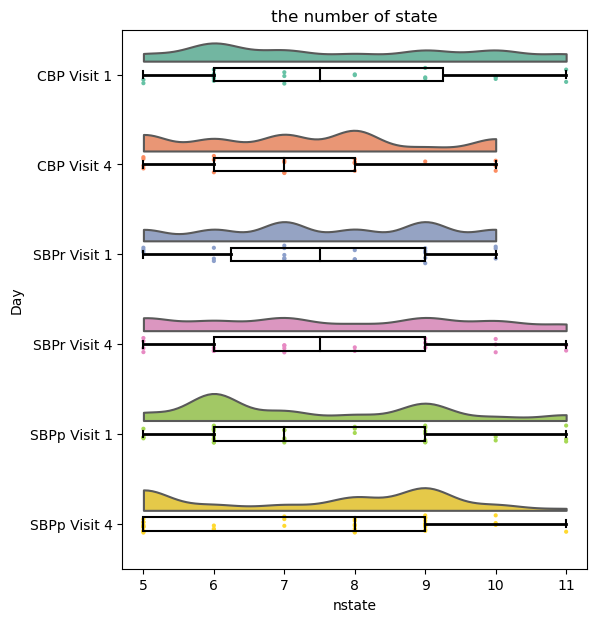

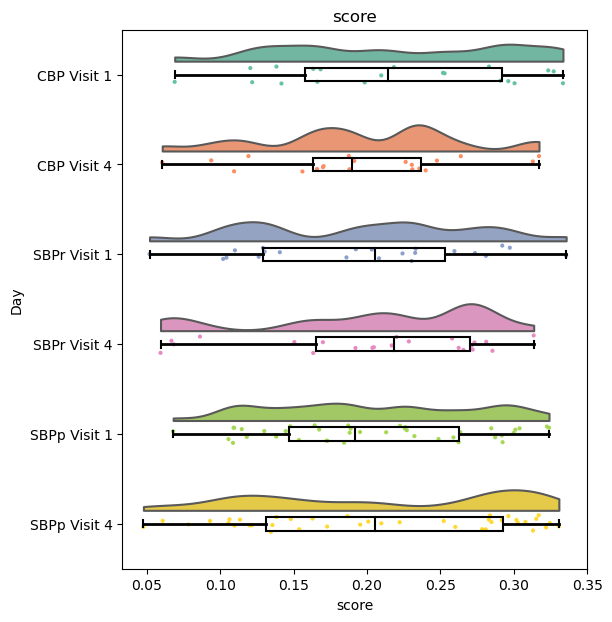

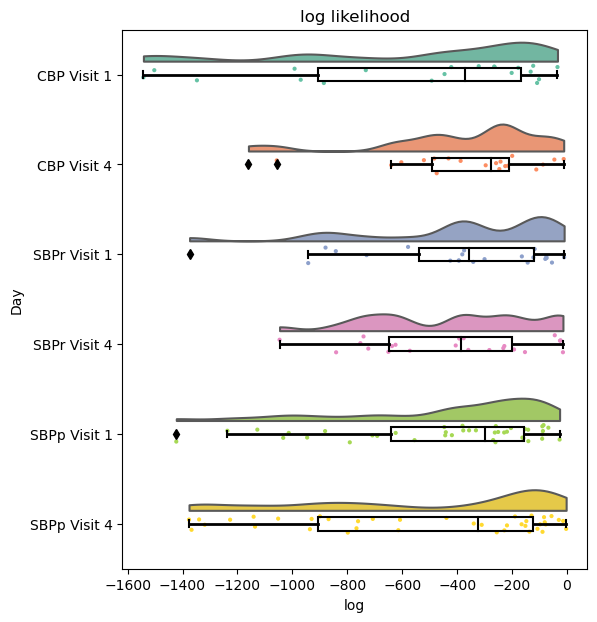

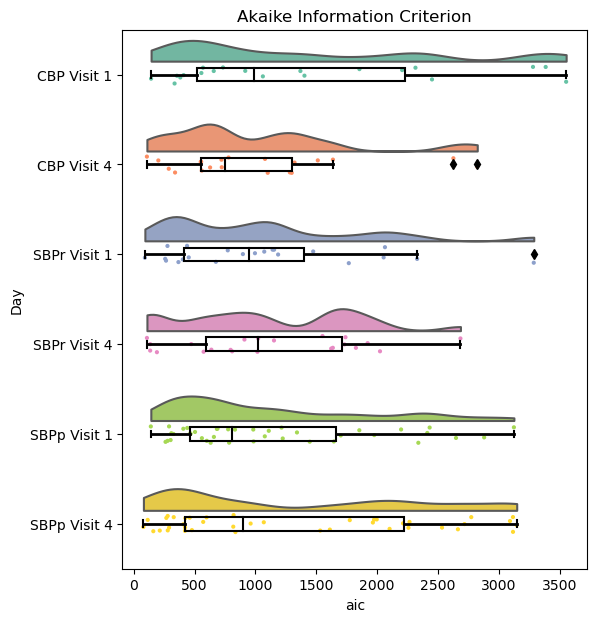

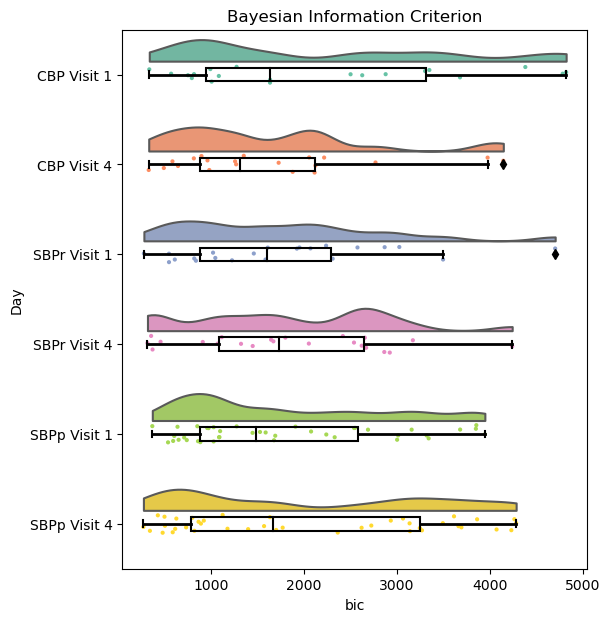

In [28]:
Group_Day_list=["CBP Visit 1"]*len(cbp_nstate_D1)+["CBP Visit 4"]*len(cbp_nstate_D4)+\
    ["SBPr Visit 1"]*len(sbpr_nstate_D1)+["SBPr Visit 4"]*len(sbpr_nstate_D4)+\
    ["SBPp Visit 1"]*len(sbpp_nstate_D1)+["SBPp Visit 4"]*len(sbpp_nstate_D4)
nstate_list=cbp_nstate_D1.tolist()+cbp_nstate_D4.tolist()+sbpr_nstate_D1.tolist()+sbpr_nstate_D4.tolist()+sbpp_nstate_D1.tolist()+sbpp_nstate_D4.tolist()
score_list=cbp_score_D1.tolist()+cbp_score_D4.tolist()+sbpr_score_D1.tolist()+sbpr_score_D4.tolist()+sbpp_score_D1.tolist()+sbpp_score_D4.tolist()
log_list=cbp_log_D1.tolist()+cbp_log_D4.tolist()+sbpr_log_D1.tolist()+sbpr_log_D4.tolist()+sbpp_log_D1.tolist()+sbpp_log_D4.tolist()
aic_list=cbp_aic_D1.tolist()+cbp_aic_D4.tolist()+sbpr_aic_D1.tolist()+sbpr_aic_D4.tolist()+sbpp_aic_D1.tolist()+sbpp_aic_D4.tolist()
bic_list=cbp_bic_D1.tolist()+cbp_bic_D4.tolist()+sbpr_bic_D1.tolist()+sbpr_bic_D4.tolist()+sbpp_bic_D1.tolist()+sbpp_bic_D4.tolist()
raincloud_df=pd.DataFrame({
    "Day": Group_Day_list,
    "nstate": nstate_list,
    "score": score_list,
    "log":log_list,
    "aic":aic_list,
    "bic":bic_list
})
dy="Day"; dx="nstate"; ort="h"; pal = "Set2"
plt.figure(figsize=(6, 7))
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("the number of state")
plt.show()
plt.figure(figsize=(6, 7))
dy="Day"; dx="score"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("score")
plt.show()
plt.figure(figsize=(6, 7))
dy="Day"; dx="log"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("log likelihood")
plt.show()
plt.figure(figsize=(6, 7))
dy="Day"; dx="aic"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("Akaike Information Criterion")
plt.show()
plt.figure(figsize=(6, 7))
dy="Day"; dx="bic"; ort="h"; pal = "Set2"
ax=pt.half_violinplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                      bw = .2, cut = 0.,scale = "area", width = .6, \
                        inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = raincloud_df, palette = pal, \
                 edgecolor = "white",size = 3, jitter = 1, zorder = 0, \
                    orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = raincloud_df, color = "black", \
               width = .15, zorder = 10, showcaps = True, \
                boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, \
                    whiskerprops = {'linewidth':2, "zorder":10}, \
                        saturation = 1, orient = ort)
plt.title("Bayesian Information Criterion")
plt.show()

----------the best number of hidden state----------


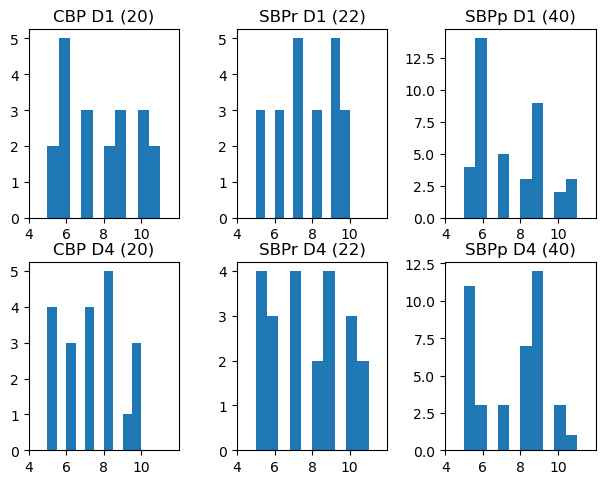

In [12]:
print("----------the best number of hidden state----------")
# plt.figure(figsize=(20, 6))
fig, ax = plt.subplots(2,3)
fig.tight_layout()
plt.subplot(2, 3, 1)
plt.hist(cbp_nstate_D1)
plt.xlim(4,12)
plt.xticks(np.arange(4,12,2))
# plt.yticks(np.arange(0,16,5))
plt.title("CBP D1 (20)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 4)
plt.hist(cbp_nstate_D4)
plt.xlim(4,12)
plt.xticks(np.arange(4,12,2))
# plt.yticks(np.arange(0,16,5))
plt.title("CBP D4 (20)")
plt.subplot(2, 3, 2)
plt.hist(sbpr_nstate_D1)
plt.xlim(4,12)
plt.xticks(np.arange(4,12,2))
# plt.yticks(np.arange(0,16,5))
plt.title("SBPr D1 (22)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 5)
plt.hist(sbpr_nstate_D4)
plt.xlim(4,12)
plt.xticks(np.arange(4,12,2))
# plt.yticks(np.arange(0,16,5))
plt.title("SBPr D4 (22)")
plt.subplot(2, 3, 3)
plt.hist(sbpp_nstate_D1)
plt.xlim(4,12)
plt.xticks(np.arange(4,12,2))
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D1 (40)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 6)
plt.hist(sbpp_nstate_D4)
plt.xlim(4,12)
plt.xticks(np.arange(4,12,2))
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D4 (40)")
plt.show()

----------CBP----------


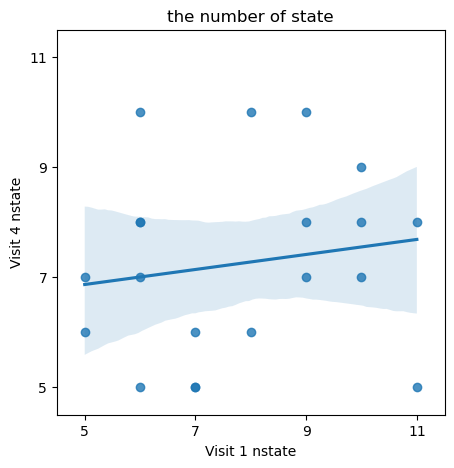

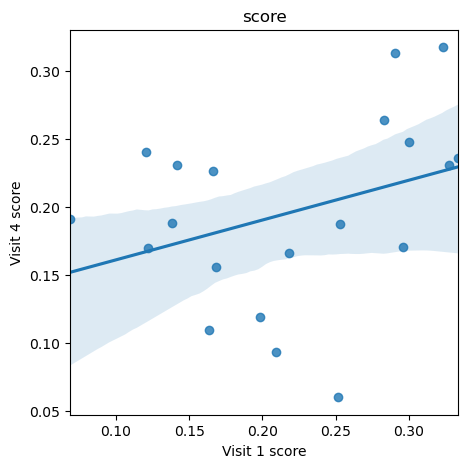

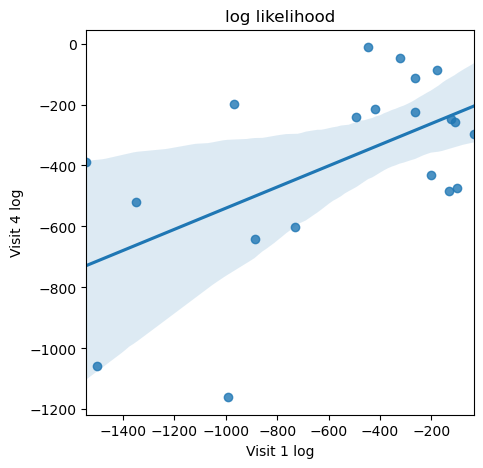

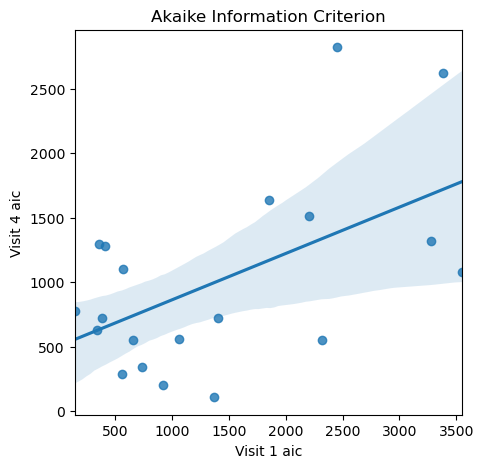

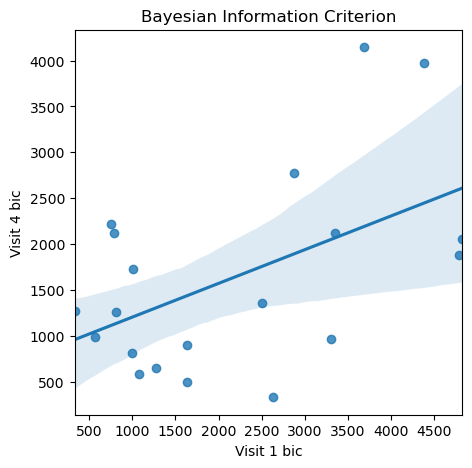

In [8]:
print("----------CBP----------")
D1D4_nstate_cbp=pd.DataFrame({
    'Day1_nstate':cbp_nstate_D1,
    'Day4_nstate':cbp_nstate_D4
})
D1D4_score_cbp=pd.DataFrame({
    'Day1_score':cbp_score_D1,
    'Day4_score':cbp_score_D4
})
D1D4_log_cbp=pd.DataFrame({
    'Day1_log':cbp_log_D1,
    'Day4_log':cbp_log_D4
})
D1D4_aic_cbp=pd.DataFrame({
    'Day1_aic':cbp_aic_D1,
    'Day4_aic':cbp_aic_D4
})
D1D4_bic_cbp=pd.DataFrame({
    'Day1_bic':cbp_bic_D1,
    'Day4_bic':cbp_bic_D4
})
# fig, axes = plt.subplots(2,3,figsize=(12,8.3))
# fig.suptitle("Correlation of Day 1 and Day 2 data among 58 participants")
# fig.tight_layout()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_nstate", y="Day4_nstate", data=D1D4_nstate_cbp)#,ax=axes[0,0])
plt.xlabel('Visit 1 nstate')
plt.ylabel('Visit 4 nstate')
plt.xlim(4.5,11.5)
plt.xticks(np.arange(5,12,2))
plt.ylim(4.5,11.5)
plt.yticks(np.arange(5,12,2))
plt.title("the number of state")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_score", y="Day4_score", data=D1D4_score_cbp)#,ax=axes[0,1])
plt.xlabel('Visit 1 score')
plt.ylabel('Visit 4 score')
# plt.xlim(0.14,0.45)
# plt.xticks(np.arange(0.2,0.5,0.1))
# plt.ylim(0.14,0.45)
# plt.yticks(np.arange(0.2,0.5,0.1))
plt.title("score")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_log", y="Day4_log", data=D1D4_log_cbp)#,ax=axes[0,2])
plt.xlabel('Visit 1 log')
plt.ylabel('Visit 4 log')
# plt.xlim(-1800,0)
# plt.xticks(np.arange(-1500,0,1000))
# plt.ylim(-1800,0)
# plt.yticks(np.arange(-1500,0,1000))
plt.title("log likelihood")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_aic", y="Day4_aic", data=D1D4_aic_cbp)#,ax=axes[1,0])
plt.xlabel('Visit 1 aic')
plt.ylabel('Visit 4 aic')
# plt.xlim(0,4000)
# plt.xticks(np.arange(0,4000,1000))
# plt.ylim(0,4000)
# plt.yticks(np.arange(0,4000,1000))
plt.title("Akaike Information Criterion")
plt.show()
plt.figure(figsize=(5, 5))
sns.regplot(x="Day1_bic", y="Day4_bic", data=D1D4_bic_cbp)#,ax=axes[1,1])
plt.xlabel('Visit 1 bic')
plt.ylabel('Visit 4 bic')
# plt.xlim(0,5000)
# plt.ylim(0,5000)
plt.title("Bayesian Information Criterion")
plt.show()

In [10]:
P_r_nstate=stats.pearsonr(D1D4_nstate_cbp['Day1_nstate'], D1D4_nstate_cbp['Day4_nstate'])
P_r_score=stats.pearsonr(D1D4_score_cbp['Day1_score'], D1D4_score_cbp['Day4_score'])
P_r_log=stats.pearsonr(D1D4_log_cbp['Day1_log'], D1D4_log_cbp['Day4_log'])
P_r_aic=stats.pearsonr(D1D4_aic_cbp['Day1_aic'], D1D4_aic_cbp['Day4_aic'])
P_r_bic=stats.pearsonr(D1D4_bic_cbp['Day1_bic'], D1D4_bic_cbp['Day4_bic'])
print(P_r_nstate)
print(P_r_score)
print(P_r_log)
print(P_r_aic)
print(P_r_bic)

(0.1594245593160039, 0.5019816416954223)
(0.3439667188088344, 0.1375525652989447)
(0.5570591257352528, 0.010727069409648477)
(0.5439038865920802, 0.013174582681941804)
(0.5094792614876735, 0.02175784518319632)


In [34]:
P_r_nstate=stats.pearsonr(sbpp_nstate_D1, sbpp_nstate_D4)
P_r_score=stats.pearsonr(sbpp_score_D1, sbpp_score_D4)
P_r_log=stats.pearsonr(sbpp_log_D1, sbpp_log_D4)
P_r_aic=stats.pearsonr(sbpp_aic_D1, sbpp_aic_D4)
P_r_bic=stats.pearsonr(sbpp_bic_D1, sbpp_bic_D4)
print(P_r_nstate)
print(P_r_score)
print(P_r_log)
print(P_r_aic)
print(P_r_bic)

(0.24978899753610187, 0.12007333875245428)
(0.4121810647105652, 0.008221405726219148)
(0.31206293295360577, 0.04995627488609732)
(0.3295626136546306, 0.037833462718773817)
(0.35321870731852223, 0.025369670829175506)


In [ ]:
P_r_nstate=stats.pearsonr(sbpr_nstate_D1, sbpr_nstate_D4)
P_r_score=stats.pearsonr(sbpr_score_D1, sbpr_score_D4)
P_r_log=stats.pearsonr(sbpr_log_D1, sbpr_log_D4)
P_r_aic=stats.pearsonr(sbpr_aic_D1, sbpr_aic_D4)
P_r_bic=stats.pearsonr(sbpr_bic_D1, sbpr_bic_D4)
print(P_r_nstate)
print(P_r_score)
print(P_r_log)
print(P_r_aic)
print(P_r_bic)

----------the best score----------


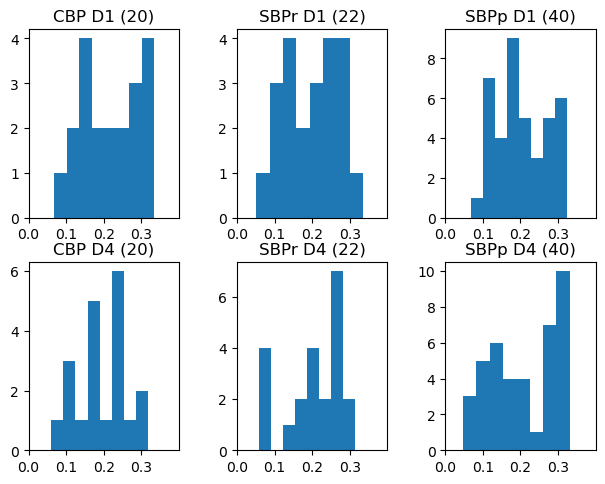

In [15]:
print("----------the best score----------")
fig, ax = plt.subplots(2,3)
fig.tight_layout()
plt.subplot(2, 3, 1)
plt.hist(cbp_score_D1,bins=8)
plt.xlim(0,0.4)
plt.xticks(np.arange(0,0.4,0.1))
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D1 (20)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 4)
plt.hist(cbp_score_D4,bins=8)
plt.xlim(0,0.4)
plt.xticks(np.arange(0,0.4,0.1))
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D4 (20)")
plt.subplot(2, 3, 2)
plt.hist(sbpr_score_D1,bins=8)
plt.xlim(0,0.4)
plt.xticks(np.arange(0,0.4,0.1))
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D1 (22)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 5)
plt.hist(sbpr_score_D4,bins=8)
plt.xlim(0,0.4)
plt.xticks(np.arange(0,0.4,0.1))
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D4 (22)")
plt.subplot(2, 3, 3)
plt.hist(sbpp_score_D1,bins=8)
plt.xlim(0,0.4)
plt.xticks(np.arange(0,0.4,0.1))
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D1 (40)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 6)
plt.hist(sbpp_score_D4,bins=8)
plt.xlim(0,0.4)
plt.xticks(np.arange(0,0.4,0.1))
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D4 (40)")
plt.show()

----------the best log----------


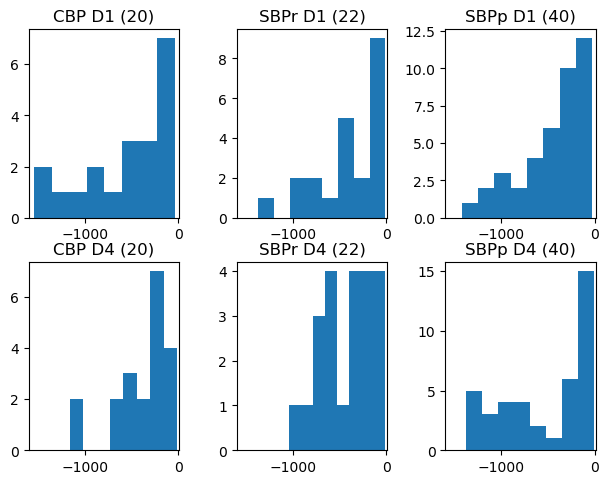

In [17]:
print("----------the best log----------")
fig, ax = plt.subplots(2,3)
fig.tight_layout()
plt.subplot(2, 3, 1)
plt.hist(cbp_log_D1,bins=8)
plt.xlim(-1600,10)
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D1 (20)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 4)
plt.hist(cbp_log_D4,bins=8)
plt.xlim(-1600,10)
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D4 (20)")
plt.subplot(2, 3, 2)
plt.hist(sbpr_log_D1,bins=8)
plt.xlim(-1600,10)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D1 (22)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 5)
plt.hist(sbpr_log_D4,bins=8)
plt.xlim(-1600,10)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D4 (22)")
plt.subplot(2, 3, 3)
plt.hist(sbpp_log_D1,bins=8)
plt.xlim(-1600,10)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D1 (40)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 6)
plt.hist(sbpp_log_D4,bins=8)
plt.xlim(-1600,10)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D4 (40)")
plt.show()

----------the best aic----------


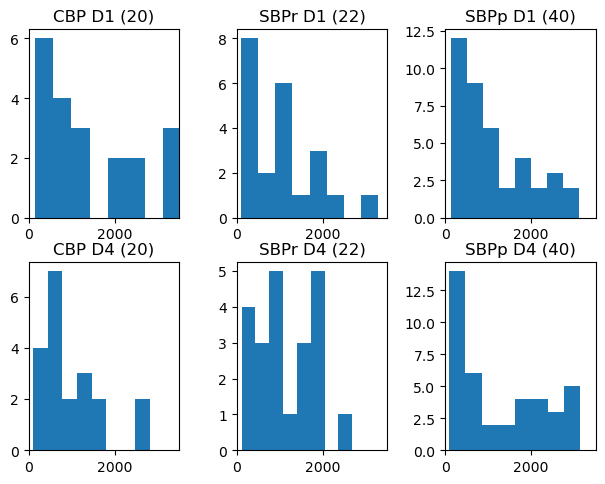

In [19]:
print("----------the best aic----------")
fig, ax = plt.subplots(2,3)
fig.tight_layout()
plt.subplot(2, 3, 1)
plt.hist(cbp_aic_D1,bins=8)
plt.xlim(0,3500)
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D1 (20)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 4)
plt.hist(cbp_aic_D4,bins=8)
plt.xlim(0,3500)
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D4 (20)")
plt.subplot(2, 3, 2)
plt.hist(sbpr_aic_D1,bins=8)
plt.xlim(0,3500)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D1 (22)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 5)
plt.hist(sbpr_aic_D4,bins=8)
plt.xlim(0,3500)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D4 (22)")
plt.subplot(2, 3, 3)
plt.hist(sbpp_aic_D1,bins=8)
plt.xlim(0,3500)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D1 (40)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 6)
plt.hist(sbpp_aic_D4,bins=8)
plt.xlim(0,3500)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D4 (40)")
plt.show()

----------the best bic----------


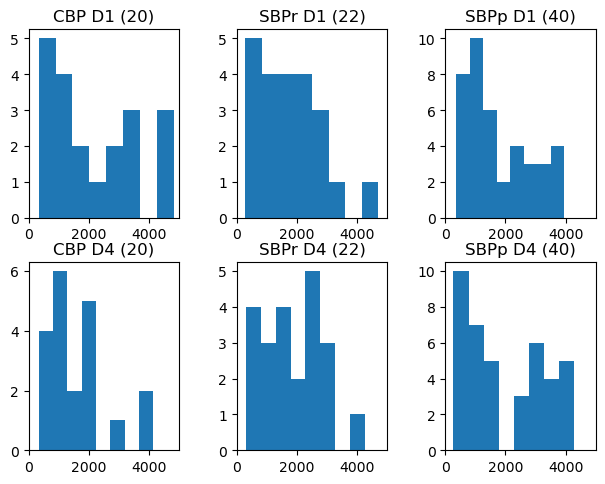

In [21]:
print("----------the best bic----------")
fig, ax = plt.subplots(2,3)
fig.tight_layout()
plt.subplot(2, 3, 1)
plt.hist(cbp_bic_D1,bins=8)
plt.xlim(0,5000)
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D1 (20)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 4)
plt.hist(cbp_bic_D4,bins=8)
plt.xlim(0,5000)
# plt.yticks(np.arange(0,26,5))
plt.title("CBP D4 (20)")
plt.subplot(2, 3, 2)
plt.hist(sbpr_bic_D1,bins=8)
plt.xlim(0,5000)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D1 (22)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 5)
plt.hist(sbpr_bic_D4,bins=8)
plt.xlim(0,5000)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPr D4 (22)")
plt.subplot(2, 3, 3)
plt.hist(sbpp_bic_D1,bins=8)
plt.xlim(0,5000)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D1 (40)")
# plt.xlabel("the number of states")
plt.subplot(2, 3, 6)
plt.hist(sbpp_bic_D4,bins=8)
plt.xlim(0,5000)
# plt.yticks(np.arange(0,26,5))
plt.title("SBPp D4 (40)")
plt.show()